# Range finder Sensor: Measurement accuracy

After finally finishing my Bayesian Statistics course on Coursera, I am ready to get back to the robot, and apply some Bayes to it. Specifically to the problem of the range sensor on the front of the robot.

One thing to note about this range sensor is that there are two worrying things. The first is that there is noise in the sensor, and intermitantly we get drop out, where the signal suddenly changes and gives a reading totally different from the actual reading. The second is that there are multiple settings for the sensor, short range, midrange and long range. This if set wrong we will get different values.

So what we want to know is given the previous readings how is the most likely actual reading from the sensor. This is our Bayes problem.


## 1 Getting data from the sensor

The sensor we are using is a [VL53L1X](https://shop.pimoroni.com/products/vl53l1x-breakout?variant=12628497236051&currency=GBP&utm_source=google&utm_medium=cpc&utm_campaign=google+shopping&gclid=Cj0KCQjwr-_tBRCMARIsAN413WQmF6fNsiDQaHC_629bE0U6i0F41t1nlrHXAoLqquOVwQN3gdpy2dIaAtFCEALw_wcB) from PiMoroni. I have added some [code to my git]() so you can run the sensor and get the data too. However its in Python 2. I then placed the robot facing the ceiling, and ran the sensor for 100 seconds on each range setting in that position. I then randomly went higher and lower with the robot, to get different fixed heights.

## 2 Initial Analysis

### 2.1 Loading the libraries and data

The libraries we want are pretty standard. Scipy stats might be needed to do some of the statistics later, while the data is in numpy arrays in csv files so we don't need pandas.

The file structure is:

'distancetestdata_' + position + setting + '.csv'

Setting is the range setting either 1= short range, 2= mid range and 3= long range, and position is the average of the range 1 data at a given set position.

From this we can write a function that spits out a dictionary for a given trial, consisting of multiple list, one for each setting.

We also want a second function to make dictionary for all the trials, where each entry in the dictionary is a dictionary of lists for each range, made from the previous function. 

In [96]:
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

In [110]:
def GetPositionData(position):
    # make an dictionary of the different arrays
    array_dict = dict()

    range_settings = [1, 2 ,3]

    # loop through the different range settings
    for setting in range_settings:
        filename = 'distancetestdata_' + str(position) + '_' + str(setting) + '.csv'
        array_dict[setting] = np.genfromtxt(filename, delimiter=',')
        
    return array_dict

In [113]:
def GetTrialsData(trials):
    range_settings = [1, 2 ,3]

    # make an dictionary of the different arrays
    trials_dict = dict()

    # loop through the different range settings
    for trial in trials:
        range_dict = GetData(trial)
        trials_dict[trial] = range_dict
    
    return trials_dict

In [114]:
trials = [323, 439, 501, 1471, 1611, 1730, 1868]
trials_dict = GetTrialsData(trials)

### 2.2 Plotting

#### 2.2.1 Salient information for a position

The first thing we want to plot is 4 plots for a position the robot has been set at. One plot of the data with time, along with 3 histograms for the data at each range setting.

In [151]:
def PlotSettingHist(array_dict):
    colors = ['r', 'g', 'b']
    range_settings = [1, 2 ,3]

    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,7))

    # reshape the axes location matrix
    axes = axes.reshape(-1)

    for i, setting in enumerate(range_settings):
        time = array_dict[setting][:,0]
        data = array_dict[setting][:,1]
        
        # number of std devs that count for an outlier
        m_out = 0.10
        mode = stats.mode(data)[0][0]
        mean = np.mean(data)
        data_no_outliers = data[data != 0]#data[abs(data - mode) < m_out * mode]

        # set the bin ranges m_bin = num stdevs for bin range
        m_bin = 10
        binrange_l = int(np.mean(data_no_outliers) - m_bin * np.std(data_no_outliers))
        binrange_u = int(np.mean(data_no_outliers) + m_bin * np.std(data_no_outliers))
        binrange = np.arange(binrange_l, binrange_u, 1)

        # plot the time series
        label_name = 'Setting = ' + str(setting)  
        axes[0].plot(time, data, alpha=0.6,
                     color=colors[i], marker='o', linestyle='none', markersize=3, label=label_name)
        axes[0].legend(loc='upper right')
        axes[0].set_title('Distance [mm], vs. Time [sec]', loc='left')

        # histogram
        #axes[i + 1].hist(data_no_outliers, bins=binrange, facecolor=colors[i], alpha=0.75)
        #axes[i + 1].set_title('Histogram - {}'.format(label_name), loc='left')
        axes[i + 1].hist(data, bins=50, facecolor=colors[i], alpha=0.75)
        axes[i + 1].set_title('Histogram - {}'.format(label_name), loc='left')

    plt.tight_layout()
    plt.show()

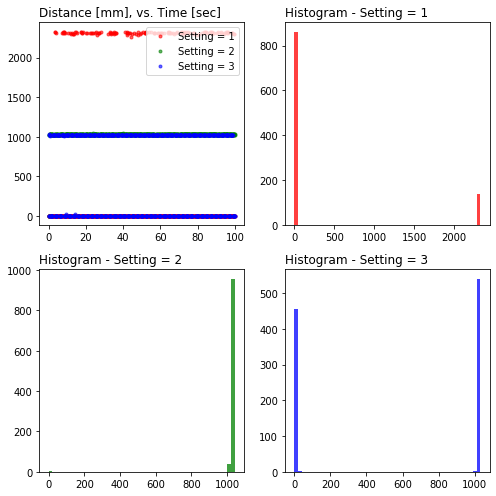

In [152]:
PlotSettingHist(trials_dict[323])

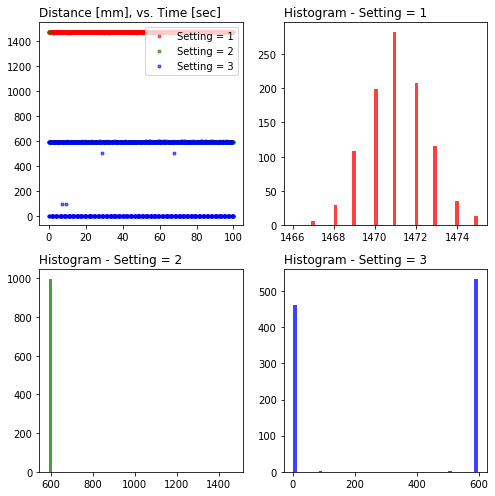

In [153]:
PlotSettingHist(trials_dict[1471])

Now we see that there are lots of scattered points. Particularly around zero.

In [178]:
def PlotSettingHistNoOutliers(array_dict):
    colors = ['r', 'g', 'b']
    range_settings = [1, 2 ,3]

    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,7))

    # reshape the axes location matrix
    axes = axes.reshape(-1)

    for i, setting in enumerate(range_settings):
        time = array_dict[setting][:,0]
        data = array_dict[setting][:,1]
        
        # remove the zero values
        time = time[data != 0]
        data = data[data != 0]
        
        # fraction of mode that counts for an outlier
        m_out = 0.10
        mode = stats.mode(data)[0][0]
        data_no_outliers = data[abs(data - mode) < m_out * mode]
        
        # set the bin ranges m_bin = num stdevs for bin range
        m_bin = 10
        #binrange_l = int(np.mean(data_no_outliers) - m_bin * np.std(data_no_outliers))
        #binrange_u = int(np.mean(data_no_outliers) + m_bin * np.std(data_no_outliers))
        
        
        binrange_l = int(mode * (1 - 0.1*m_out))
        binrange_u = int(mode * (1 + 0.1*m_out))
        binrange = np.arange(binrange_l, binrange_u, 1)
        
        norm_data = data - mode

        # plot the normalised time series
        label_name = 'Setting = ' + str(setting)  
        axes[0].plot(time, norm_data, alpha=0.6,
                     color=colors[i], marker='o', linestyle='none', markersize=3, label=label_name)
        axes[0].legend(loc='upper right')
        axes[0].set_title('Norm Distance [mm], vs Time [secs]', loc='left')
        axes[0].set_ylim([-20, +20])
        
        # histogram
        axes[i + 1].hist(data_no_outliers, bins=binrange, facecolor=colors[i], alpha=0.75)
        axes[i + 1].set_title('Histogram - {}'.format(label_name), loc='left')

    plt.tight_layout()
    plt.show()

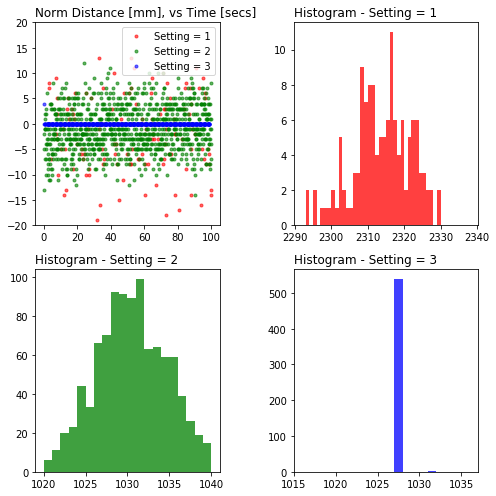

In [179]:
PlotSettingHistNoOutliers(trials_dict[323])

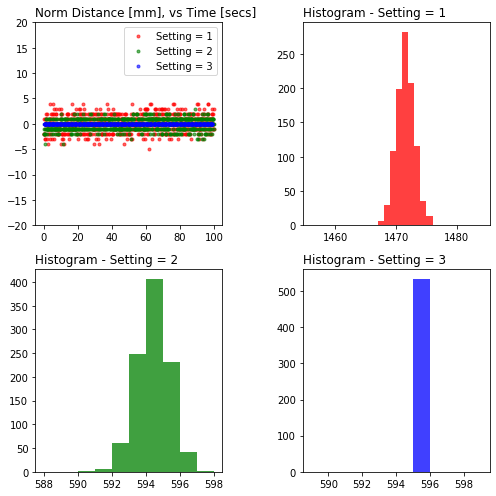

In [180]:
PlotSettingHistNoOutliers(trials_dict[1471])

### 2.2.2 Dropout

So how many are we dropping out to make the 

In [237]:
def PlotOutliers(trials_dict):
    colors = ['r', 'g', 'b']
    range_settings = [1, 2 ,3]

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5)) 
    
    # the labels on the x axis
    labels = trials_dict.keys()
    
    # the label locations
    x =  np.arange(len(labels))
    
    # width of the bars
    width = 0.7
    
    for i, (trial, array_dict) in enumerate(trials_dict.items()):
        for j, setting in enumerate(range_settings):
            time = array_dict[setting][:,0]
            data = array_dict[setting][:,1]
            
            total = data.size
            
            # number that are zero
            num_zero = data[data   == 0].size/total
        
            # remove the zero values
            time = time[data != 0]
            data = data[data != 0]
            
            # number of std devations
            m_out = 3
            
            # mean and standard dev.
            mean = np.mean(data)
            std = np.std(data)
            
            # number out of number std dev
            num_out = data[abs(data - mean) > m_out * mean].size
            
            #
            total_out = num_out/total + num_zero
        
            # plot them
            zeros = ax.bar(x[i] + (-1 + j)*width, total_out, width, label='Zero')
            
    
    ax.set_ylabel('Scores')
    ax.set_title('Scores by group and gender')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    #ax.legend()
    
    plt.show()
         
        

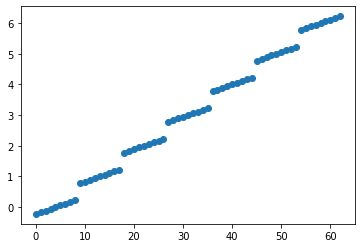

In [219]:
labels = trials_dict.keys()
x = np.arange(len(labels))
y = np.zeros(9*len(labels))
for i, (trial, array_dict) in enumerate(trials_dict.items()):
        for j, setting in enumerate(range_settings):
            y[9*i + 3*j] = x[i] + (-4 + 3*j)/9/2
            y[9*i + 3*j + 1] = x[i] + (-3 + 3*j)/9/2
            y[9*i + 3*j + 2] = x[i] + (-2 + 3*j)/9/2
            
plt.plot(y, 'o')
plt.show()

In [239]:
import Flask

ModuleNotFoundError: No module named 'Flask'

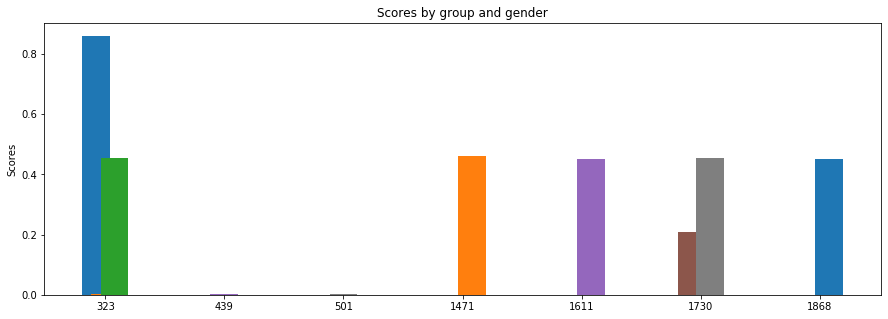

In [238]:
PlotOutliers(trials_dict)